# 你的第一个神经网络

在此项目中，你将构建你的第一个神经网络，并用该网络预测每日自行车租客人数。我们提供了一些代码，但是需要你来实现神经网络（大部分内容）。提交此项目后，欢迎进一步探索该数据和模型。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 加载和准备数据

构建神经网络的关键一步是正确地准备数据。不同尺度级别的变量使网络难以高效地掌握正确的权重。我们在下方已经提供了加载和准备数据的代码。你很快将进一步学习这些代码！

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 数据简介

此数据集包含的是从 2011 年 1 月 1 日到 2012 年 12 月 31 日期间每天每小时的骑车人数。骑车用户分成临时用户和注册用户，cnt 列是骑车用户数汇总列。你可以在上方看到前几行数据。

下图展示的是数据集中前 10 天左右的骑车人数（某些天不一定是 24 个条目，所以不是精确的 10 天）。你可以在这里看到每小时租金。这些数据很复杂！周末的骑行人数少些，工作日上下班期间是骑行高峰期。我们还可以从上方的数据中看到温度、湿度和风速信息，所有这些信息都会影响骑行人数。你需要用你的模型展示所有这些数据。

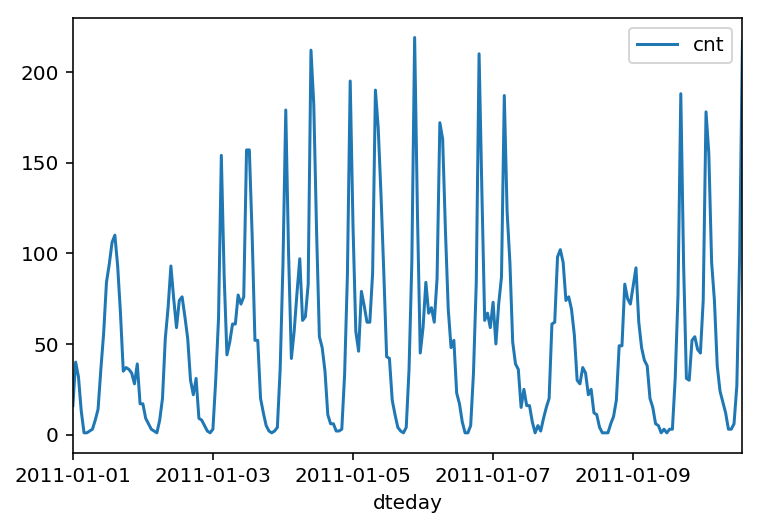

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### 虚拟变量（哑变量）

下面是一些分类变量，例如季节、天气、月份。要在我们的模型中包含这些数据，我们需要创建二进制虚拟变量。用 Pandas 库中的 `get_dummies()` 就可以轻松实现。

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### 调整目标变量

为了更轻松地训练网络，我们将对每个连续变量标准化，即转换和调整变量，使它们的均值为 0，标准差为 1。

我们会保存换算因子，以便当我们使用网络进行预测时可以还原数据。

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### 将数据拆分为训练、测试和验证数据集

我们将大约最后 21 天的数据保存为测试数据集，这些数据集会在训练完网络后使用。我们将使用该数据集进行预测，并与实际的骑行人数进行对比。

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

我们将数据拆分为两个数据集，一个用作训练，一个在网络训练完后用来验证网络。因为数据是有时间序列特性的，所以我们用历史数据进行训练，然后尝试预测未来数据（验证数据集）。

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## 开始构建网络

下面你将构建自己的网络。我们已经构建好结构和反向传递部分。你将实现网络的前向传递部分。还需要设置超参数：学习速率、隐藏单元的数量，以及训练传递数量。

<img src="assets/neural_network.png" width=300px>

该网络有两个层级，一个隐藏层和一个输出层。隐藏层级将使用 S 型函数作为激活函数。输出层只有一个节点，用于递归，节点的输出和节点的输入相同。即激活函数是 $f(x)=x$。这种函数获得输入信号，并生成输出信号，但是会考虑阈值，称为激活函数。我们完成网络的每个层级，并计算每个神经元的输出。一个层级的所有输出变成下一层级神经元的输入。这一流程叫做前向传播（forward propagation）。

我们在神经网络中使用权重将信号从输入层传播到输出层。我们还使用权重将错误从输出层传播回网络，以便更新权重。这叫做反向传播（backpropagation）。

> **提示**：你需要为反向传播实现计算输出激活函数 ($f(x) = x$) 的导数。如果你不熟悉微积分，其实该函数就等同于等式 $y = x$。该等式的斜率是多少？也就是导数 $f(x)$。


你需要完成以下任务：

1. 实现 S 型激活函数。将 `__init__` 中的 `self.activation_function`  设为你的 S 型函数。
2. 在 `train` 方法中实现前向传递。
3. 在 `train` 方法中实现反向传播算法，包括计算输出错误。
4. 在 `run` 方法中实现前向传递。

  

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
           
            
            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(error , (self.weights_hidden_to_output).T)
           
             
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            output_error_term = error
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * (X[:,None])
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        print(final_outputs.shape)
        return final_outputs

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## 单元测试

运行这些单元测试，检查你的网络实现是否正确。这样可以帮助你确保网络已正确实现，然后再开始训练网络。这些测试必须成功才能通过此项目。

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

(1, 1)



----------------------------------------------------------------------
Ran 5 tests in 0.018s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## 训练网络

现在你将设置网络的超参数。策略是设置的超参数使训练集上的错误很小但是数据不会过拟合。如果网络训练时间太长，或者有太多的隐藏节点，可能就会过于针对特定训练集，无法泛化到验证数据集。即当训练集的损失降低时，验证集的损失将开始增大。

你还将采用随机梯度下降 (SGD) 方法训练网络。对于每次训练，都获取随机样本数据，而不是整个数据集。与普通梯度下降相比，训练次数要更多，但是每次时间更短。这样的话，网络训练效率更高。稍后你将详细了解 SGD。


### 选择迭代次数

也就是训练网络时从训练数据中抽样的批次数量。迭代次数越多，模型就与数据越拟合。但是，如果迭代次数太多，模型就无法很好地泛化到其他数据，这叫做过拟合。你需要选择一个使训练损失很低并且验证损失保持中等水平的数字。当你开始过拟合时，你会发现训练损失继续下降，但是验证损失开始上升。

### 选择学习速率

速率可以调整权重更新幅度。如果速率太大，权重就会太大，导致网络无法与数据相拟合。建议从 0.1 开始。如果网络在与数据拟合时遇到问题，尝试降低学习速率。注意，学习速率越低，权重更新的步长就越小，神经网络收敛的时间就越长。


### 选择隐藏节点数量

隐藏节点越多，模型的预测结果就越准确。尝试不同的隐藏节点的数量，看看对性能有何影响。你可以查看损失字典，寻找网络性能指标。如果隐藏单元的数量太少，那么模型就没有足够的空间进行学习，如果太多，则学习方向就有太多的选择。选择隐藏单元数量的技巧在于找到合适的平衡点。

In [14]:
import sys

### Set the hyperparameters here ###
iterations = 6000
learning_rate = 0.5
hidden_nodes = 10
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

(15435, 1)
(1440, 1)
Progress: 0.0% ... Training loss: 0.964 ... Validation loss: 1.293(15435, 1)
(1440, 1)
Progress: 0.0% ... Training loss: 0.943 ... Validation loss: 1.332(15435, 1)
(1440, 1)
Progress: 0.0% ... Training loss: 0.929 ... Validation loss: 1.278(15435, 1)
(1440, 1)
Progress: 0.1% ... Training loss: 0.912 ... Validation loss: 1.322(15435, 1)
(1440, 1)
Progress: 0.1% ... Training loss: 0.895 ... Validation loss: 1.306(15435, 1)
(1440, 1)
Progress: 0.1% ... Training loss: 0.899 ... Validation loss: 1.368(15435, 1)
(1440, 1)
Progress: 0.1% ... Training loss: 0.869 ... Validation loss: 1.295(15435, 1)
(1440, 1)
Progress: 0.1% ... Training loss: 0.856 ... Validation loss: 1.286(15435, 1)
(1440, 1)
Progress: 0.1% ... Training loss: 0.840 ... Validation loss: 1.260(15435, 1)
(1440, 1)
Progress: 0.1% ... Training loss: 0.838 ... Validation loss: 1.179(15435, 1)
(1440, 1)
Progress: 0.2% ... Training loss: 0.845 ... Validation loss: 1.147(15435, 1)
(1440, 1)
Progress: 0.2% ... Tra

Progress: 1.6% ... Training loss: 0.443 ... Validation loss: 0.726(15435, 1)
(1440, 1)
Progress: 1.6% ... Training loss: 0.447 ... Validation loss: 0.734(15435, 1)
(1440, 1)
Progress: 1.6% ... Training loss: 0.438 ... Validation loss: 0.722(15435, 1)
(1440, 1)
Progress: 1.6% ... Training loss: 0.439 ... Validation loss: 0.720(15435, 1)
(1440, 1)
Progress: 1.6% ... Training loss: 0.473 ... Validation loss: 0.734(15435, 1)
(1440, 1)
Progress: 1.6% ... Training loss: 0.480 ... Validation loss: 0.761(15435, 1)
(1440, 1)
Progress: 1.7% ... Training loss: 0.447 ... Validation loss: 0.714(15435, 1)
(1440, 1)
Progress: 1.7% ... Training loss: 0.426 ... Validation loss: 0.701(15435, 1)
(1440, 1)
Progress: 1.7% ... Training loss: 0.426 ... Validation loss: 0.701(15435, 1)
(1440, 1)
Progress: 1.7% ... Training loss: 0.422 ... Validation loss: 0.698(15435, 1)
(1440, 1)
Progress: 1.7% ... Training loss: 0.421 ... Validation loss: 0.691(15435, 1)
(1440, 1)
Progress: 1.8% ... Training loss: 0.415 ...

Progress: 3.1% ... Training loss: 0.324 ... Validation loss: 0.508(15435, 1)
(1440, 1)
Progress: 3.1% ... Training loss: 0.315 ... Validation loss: 0.500(15435, 1)
(1440, 1)
Progress: 3.2% ... Training loss: 0.310 ... Validation loss: 0.489(15435, 1)
(1440, 1)
Progress: 3.2% ... Training loss: 0.310 ... Validation loss: 0.497(15435, 1)
(1440, 1)
Progress: 3.2% ... Training loss: 0.312 ... Validation loss: 0.494(15435, 1)
(1440, 1)
Progress: 3.2% ... Training loss: 0.340 ... Validation loss: 0.527(15435, 1)
(1440, 1)
Progress: 3.2% ... Training loss: 0.334 ... Validation loss: 0.510(15435, 1)
(1440, 1)
Progress: 3.2% ... Training loss: 0.310 ... Validation loss: 0.498(15435, 1)
(1440, 1)
Progress: 3.3% ... Training loss: 0.308 ... Validation loss: 0.494(15435, 1)
(1440, 1)
Progress: 3.3% ... Training loss: 0.318 ... Validation loss: 0.508(15435, 1)
(1440, 1)
Progress: 3.3% ... Training loss: 0.310 ... Validation loss: 0.499(15435, 1)
(1440, 1)
Progress: 3.3% ... Training loss: 0.331 ...

Progress: 4.7% ... Training loss: 0.291 ... Validation loss: 0.461(15435, 1)
(1440, 1)
Progress: 4.7% ... Training loss: 0.293 ... Validation loss: 0.452(15435, 1)
(1440, 1)
Progress: 4.7% ... Training loss: 0.291 ... Validation loss: 0.459(15435, 1)
(1440, 1)
Progress: 4.8% ... Training loss: 0.291 ... Validation loss: 0.460(15435, 1)
(1440, 1)
Progress: 4.8% ... Training loss: 0.292 ... Validation loss: 0.456(15435, 1)
(1440, 1)
Progress: 4.8% ... Training loss: 0.293 ... Validation loss: 0.465(15435, 1)
(1440, 1)
Progress: 4.8% ... Training loss: 0.292 ... Validation loss: 0.466(15435, 1)
(1440, 1)
Progress: 4.8% ... Training loss: 0.295 ... Validation loss: 0.469(15435, 1)
(1440, 1)
Progress: 4.8% ... Training loss: 0.307 ... Validation loss: 0.470(15435, 1)
(1440, 1)
Progress: 4.8% ... Training loss: 0.289 ... Validation loss: 0.453(15435, 1)
(1440, 1)
Progress: 4.9% ... Training loss: 0.296 ... Validation loss: 0.469(15435, 1)
(1440, 1)
Progress: 4.9% ... Training loss: 0.327 ...

Progress: 6.3% ... Training loss: 0.280 ... Validation loss: 0.458(15435, 1)
(1440, 1)
Progress: 6.3% ... Training loss: 0.284 ... Validation loss: 0.458(15435, 1)
(1440, 1)
Progress: 6.3% ... Training loss: 0.295 ... Validation loss: 0.466(15435, 1)
(1440, 1)
Progress: 6.3% ... Training loss: 0.284 ... Validation loss: 0.457(15435, 1)
(1440, 1)
Progress: 6.3% ... Training loss: 0.283 ... Validation loss: 0.446(15435, 1)
(1440, 1)
Progress: 6.3% ... Training loss: 0.280 ... Validation loss: 0.449(15435, 1)
(1440, 1)
Progress: 6.4% ... Training loss: 0.278 ... Validation loss: 0.456(15435, 1)
(1440, 1)
Progress: 6.4% ... Training loss: 0.294 ... Validation loss: 0.461(15435, 1)
(1440, 1)
Progress: 6.4% ... Training loss: 0.279 ... Validation loss: 0.454(15435, 1)
(1440, 1)
Progress: 6.4% ... Training loss: 0.289 ... Validation loss: 0.454(15435, 1)
(1440, 1)
Progress: 6.4% ... Training loss: 0.280 ... Validation loss: 0.454(15435, 1)
(1440, 1)
Progress: 6.5% ... Training loss: 0.280 ...

Progress: 7.8% ... Training loss: 0.271 ... Validation loss: 0.441(15435, 1)
(1440, 1)
Progress: 7.8% ... Training loss: 0.270 ... Validation loss: 0.442(15435, 1)
(1440, 1)
Progress: 7.9% ... Training loss: 0.273 ... Validation loss: 0.446(15435, 1)
(1440, 1)
Progress: 7.9% ... Training loss: 0.276 ... Validation loss: 0.436(15435, 1)
(1440, 1)
Progress: 7.9% ... Training loss: 0.271 ... Validation loss: 0.445(15435, 1)
(1440, 1)
Progress: 7.9% ... Training loss: 0.277 ... Validation loss: 0.447(15435, 1)
(1440, 1)
Progress: 7.9% ... Training loss: 0.272 ... Validation loss: 0.435(15435, 1)
(1440, 1)
Progress: 8.0% ... Training loss: 0.287 ... Validation loss: 0.442(15435, 1)
(1440, 1)
Progress: 8.0% ... Training loss: 0.273 ... Validation loss: 0.443(15435, 1)
(1440, 1)
Progress: 8.0% ... Training loss: 0.270 ... Validation loss: 0.441(15435, 1)
(1440, 1)
Progress: 8.0% ... Training loss: 0.271 ... Validation loss: 0.439(15435, 1)
(1440, 1)
Progress: 8.0% ... Training loss: 0.275 ...

Progress: 9.4% ... Training loss: 0.277 ... Validation loss: 0.432(15435, 1)
(1440, 1)
Progress: 9.4% ... Training loss: 0.272 ... Validation loss: 0.431(15435, 1)
(1440, 1)
Progress: 9.4% ... Training loss: 0.271 ... Validation loss: 0.424(15435, 1)
(1440, 1)
Progress: 9.4% ... Training loss: 0.289 ... Validation loss: 0.458(15435, 1)
(1440, 1)
Progress: 9.5% ... Training loss: 0.275 ... Validation loss: 0.432(15435, 1)
(1440, 1)
Progress: 9.5% ... Training loss: 0.270 ... Validation loss: 0.441(15435, 1)
(1440, 1)
Progress: 9.5% ... Training loss: 0.266 ... Validation loss: 0.430(15435, 1)
(1440, 1)
Progress: 9.5% ... Training loss: 0.285 ... Validation loss: 0.447(15435, 1)
(1440, 1)
Progress: 9.5% ... Training loss: 0.275 ... Validation loss: 0.441(15435, 1)
(1440, 1)
Progress: 9.6% ... Training loss: 0.268 ... Validation loss: 0.431(15435, 1)
(1440, 1)
Progress: 9.6% ... Training loss: 0.270 ... Validation loss: 0.430(15435, 1)
(1440, 1)
Progress: 9.6% ... Training loss: 0.267 ...

Progress: 10.9% ... Training loss: 0.263 ... Validation loss: 0.436(15435, 1)
(1440, 1)
Progress: 11.0% ... Training loss: 0.264 ... Validation loss: 0.438(15435, 1)
(1440, 1)
Progress: 11.0% ... Training loss: 0.268 ... Validation loss: 0.434(15435, 1)
(1440, 1)
Progress: 11.0% ... Training loss: 0.306 ... Validation loss: 0.463(15435, 1)
(1440, 1)
Progress: 11.0% ... Training loss: 0.300 ... Validation loss: 0.460(15435, 1)
(1440, 1)
Progress: 11.0% ... Training loss: 0.286 ... Validation loss: 0.476(15435, 1)
(1440, 1)
Progress: 11.1% ... Training loss: 0.299 ... Validation loss: 0.453(15435, 1)
(1440, 1)
Progress: 11.1% ... Training loss: 0.306 ... Validation loss: 0.503(15435, 1)
(1440, 1)
Progress: 11.1% ... Training loss: 0.261 ... Validation loss: 0.432(15435, 1)
(1440, 1)
Progress: 11.1% ... Training loss: 0.261 ... Validation loss: 0.423(15435, 1)
(1440, 1)
Progress: 11.1% ... Training loss: 0.283 ... Validation loss: 0.447(15435, 1)
(1440, 1)
Progress: 11.1% ... Training los

Progress: 12.5% ... Training loss: 0.289 ... Validation loss: 0.457(15435, 1)
(1440, 1)
Progress: 12.5% ... Training loss: 0.288 ... Validation loss: 0.454(15435, 1)
(1440, 1)
Progress: 12.5% ... Training loss: 0.266 ... Validation loss: 0.434(15435, 1)
(1440, 1)
Progress: 12.6% ... Training loss: 0.259 ... Validation loss: 0.424(15435, 1)
(1440, 1)
Progress: 12.6% ... Training loss: 0.264 ... Validation loss: 0.427(15435, 1)
(1440, 1)
Progress: 12.6% ... Training loss: 0.260 ... Validation loss: 0.423(15435, 1)
(1440, 1)
Progress: 12.6% ... Training loss: 0.270 ... Validation loss: 0.437(15435, 1)
(1440, 1)
Progress: 12.6% ... Training loss: 0.263 ... Validation loss: 0.428(15435, 1)
(1440, 1)
Progress: 12.6% ... Training loss: 0.262 ... Validation loss: 0.433(15435, 1)
(1440, 1)
Progress: 12.7% ... Training loss: 0.258 ... Validation loss: 0.427(15435, 1)
(1440, 1)
Progress: 12.7% ... Training loss: 0.258 ... Validation loss: 0.422(15435, 1)
(1440, 1)
Progress: 12.7% ... Training los

Progress: 14.1% ... Training loss: 0.260 ... Validation loss: 0.421(15435, 1)
(1440, 1)
Progress: 14.1% ... Training loss: 0.271 ... Validation loss: 0.447(15435, 1)
(1440, 1)
Progress: 14.1% ... Training loss: 0.255 ... Validation loss: 0.425(15435, 1)
(1440, 1)
Progress: 14.1% ... Training loss: 0.295 ... Validation loss: 0.445(15435, 1)
(1440, 1)
Progress: 14.1% ... Training loss: 0.259 ... Validation loss: 0.426(15435, 1)
(1440, 1)
Progress: 14.1% ... Training loss: 0.264 ... Validation loss: 0.427(15435, 1)
(1440, 1)
Progress: 14.2% ... Training loss: 0.255 ... Validation loss: 0.420(15435, 1)
(1440, 1)
Progress: 14.2% ... Training loss: 0.255 ... Validation loss: 0.421(15435, 1)
(1440, 1)
Progress: 14.2% ... Training loss: 0.256 ... Validation loss: 0.424(15435, 1)
(1440, 1)
Progress: 14.2% ... Training loss: 0.256 ... Validation loss: 0.422(15435, 1)
(1440, 1)
Progress: 14.2% ... Training loss: 0.256 ... Validation loss: 0.421(15435, 1)
(1440, 1)
Progress: 14.2% ... Training los

Progress: 15.6% ... Training loss: 0.263 ... Validation loss: 0.426(15435, 1)
(1440, 1)
Progress: 15.6% ... Training loss: 0.251 ... Validation loss: 0.411(15435, 1)
(1440, 1)
Progress: 15.6% ... Training loss: 0.261 ... Validation loss: 0.420(15435, 1)
(1440, 1)
Progress: 15.7% ... Training loss: 0.254 ... Validation loss: 0.424(15435, 1)
(1440, 1)
Progress: 15.7% ... Training loss: 0.255 ... Validation loss: 0.430(15435, 1)
(1440, 1)
Progress: 15.7% ... Training loss: 0.250 ... Validation loss: 0.415(15435, 1)
(1440, 1)
Progress: 15.7% ... Training loss: 0.261 ... Validation loss: 0.423(15435, 1)
(1440, 1)
Progress: 15.7% ... Training loss: 0.253 ... Validation loss: 0.419(15435, 1)
(1440, 1)
Progress: 15.7% ... Training loss: 0.251 ... Validation loss: 0.416(15435, 1)
(1440, 1)
Progress: 15.8% ... Training loss: 0.263 ... Validation loss: 0.428(15435, 1)
(1440, 1)
Progress: 15.8% ... Training loss: 0.254 ... Validation loss: 0.420(15435, 1)
(1440, 1)
Progress: 15.8% ... Training los

Progress: 17.1% ... Training loss: 0.252 ... Validation loss: 0.408(15435, 1)
(1440, 1)
Progress: 17.2% ... Training loss: 0.254 ... Validation loss: 0.410(15435, 1)
(1440, 1)
Progress: 17.2% ... Training loss: 0.246 ... Validation loss: 0.405(15435, 1)
(1440, 1)
Progress: 17.2% ... Training loss: 0.253 ... Validation loss: 0.411(15435, 1)
(1440, 1)
Progress: 17.2% ... Training loss: 0.249 ... Validation loss: 0.403(15435, 1)
(1440, 1)
Progress: 17.2% ... Training loss: 0.264 ... Validation loss: 0.425(15435, 1)
(1440, 1)
Progress: 17.2% ... Training loss: 0.249 ... Validation loss: 0.420(15435, 1)
(1440, 1)
Progress: 17.3% ... Training loss: 0.245 ... Validation loss: 0.410(15435, 1)
(1440, 1)
Progress: 17.3% ... Training loss: 0.251 ... Validation loss: 0.407(15435, 1)
(1440, 1)
Progress: 17.3% ... Training loss: 0.247 ... Validation loss: 0.408(15435, 1)
(1440, 1)
Progress: 17.3% ... Training loss: 0.248 ... Validation loss: 0.406(15435, 1)
(1440, 1)
Progress: 17.3% ... Training los

Progress: 18.7% ... Training loss: 0.241 ... Validation loss: 0.400(15435, 1)
(1440, 1)
Progress: 18.7% ... Training loss: 0.242 ... Validation loss: 0.408(15435, 1)
(1440, 1)
Progress: 18.7% ... Training loss: 0.241 ... Validation loss: 0.405(15435, 1)
(1440, 1)
Progress: 18.8% ... Training loss: 0.240 ... Validation loss: 0.401(15435, 1)
(1440, 1)
Progress: 18.8% ... Training loss: 0.246 ... Validation loss: 0.412(15435, 1)
(1440, 1)
Progress: 18.8% ... Training loss: 0.242 ... Validation loss: 0.401(15435, 1)
(1440, 1)
Progress: 18.8% ... Training loss: 0.244 ... Validation loss: 0.405(15435, 1)
(1440, 1)
Progress: 18.8% ... Training loss: 0.240 ... Validation loss: 0.398(15435, 1)
(1440, 1)
Progress: 18.8% ... Training loss: 0.249 ... Validation loss: 0.413(15435, 1)
(1440, 1)
Progress: 18.9% ... Training loss: 0.240 ... Validation loss: 0.399(15435, 1)
(1440, 1)
Progress: 18.9% ... Training loss: 0.239 ... Validation loss: 0.403(15435, 1)
(1440, 1)
Progress: 18.9% ... Training los

Progress: 20.2% ... Training loss: 0.235 ... Validation loss: 0.396(15435, 1)
(1440, 1)
Progress: 20.3% ... Training loss: 0.248 ... Validation loss: 0.401(15435, 1)
(1440, 1)
Progress: 20.3% ... Training loss: 0.241 ... Validation loss: 0.394(15435, 1)
(1440, 1)
Progress: 20.3% ... Training loss: 0.236 ... Validation loss: 0.392(15435, 1)
(1440, 1)
Progress: 20.3% ... Training loss: 0.234 ... Validation loss: 0.391(15435, 1)
(1440, 1)
Progress: 20.3% ... Training loss: 0.233 ... Validation loss: 0.392(15435, 1)
(1440, 1)
Progress: 20.4% ... Training loss: 0.232 ... Validation loss: 0.394(15435, 1)
(1440, 1)
Progress: 20.4% ... Training loss: 0.240 ... Validation loss: 0.394(15435, 1)
(1440, 1)
Progress: 20.4% ... Training loss: 0.266 ... Validation loss: 0.418(15435, 1)
(1440, 1)
Progress: 20.4% ... Training loss: 0.261 ... Validation loss: 0.421(15435, 1)
(1440, 1)
Progress: 20.4% ... Training loss: 0.270 ... Validation loss: 0.416(15435, 1)
(1440, 1)
Progress: 20.4% ... Training los

Progress: 21.8% ... Training loss: 0.225 ... Validation loss: 0.371(15435, 1)
(1440, 1)
Progress: 21.8% ... Training loss: 0.228 ... Validation loss: 0.371(15435, 1)
(1440, 1)
Progress: 21.8% ... Training loss: 0.237 ... Validation loss: 0.392(15435, 1)
(1440, 1)
Progress: 21.9% ... Training loss: 0.224 ... Validation loss: 0.373(15435, 1)
(1440, 1)
Progress: 21.9% ... Training loss: 0.236 ... Validation loss: 0.376(15435, 1)
(1440, 1)
Progress: 21.9% ... Training loss: 0.227 ... Validation loss: 0.370(15435, 1)
(1440, 1)
Progress: 21.9% ... Training loss: 0.223 ... Validation loss: 0.374(15435, 1)
(1440, 1)
Progress: 21.9% ... Training loss: 0.229 ... Validation loss: 0.384(15435, 1)
(1440, 1)
Progress: 21.9% ... Training loss: 0.229 ... Validation loss: 0.371(15435, 1)
(1440, 1)
Progress: 21.9% ... Training loss: 0.221 ... Validation loss: 0.367(15435, 1)
(1440, 1)
Progress: 22.0% ... Training loss: 0.228 ... Validation loss: 0.379(15435, 1)
(1440, 1)
Progress: 22.0% ... Training los

Progress: 23.4% ... Training loss: 0.213 ... Validation loss: 0.353(15435, 1)
(1440, 1)
Progress: 23.4% ... Training loss: 0.212 ... Validation loss: 0.353(15435, 1)
(1440, 1)
Progress: 23.4% ... Training loss: 0.215 ... Validation loss: 0.360(15435, 1)
(1440, 1)
Progress: 23.4% ... Training loss: 0.227 ... Validation loss: 0.366(15435, 1)
(1440, 1)
Progress: 23.4% ... Training loss: 0.231 ... Validation loss: 0.383(15435, 1)
(1440, 1)
Progress: 23.4% ... Training loss: 0.224 ... Validation loss: 0.358(15435, 1)
(1440, 1)
Progress: 23.4% ... Training loss: 0.212 ... Validation loss: 0.358(15435, 1)
(1440, 1)
Progress: 23.5% ... Training loss: 0.213 ... Validation loss: 0.356(15435, 1)
(1440, 1)
Progress: 23.5% ... Training loss: 0.229 ... Validation loss: 0.376(15435, 1)
(1440, 1)
Progress: 23.5% ... Training loss: 0.234 ... Validation loss: 0.376(15435, 1)
(1440, 1)
Progress: 23.5% ... Training loss: 0.257 ... Validation loss: 0.391(15435, 1)
(1440, 1)
Progress: 23.5% ... Training los

Progress: 24.9% ... Training loss: 0.202 ... Validation loss: 0.341(15435, 1)
(1440, 1)
Progress: 24.9% ... Training loss: 0.204 ... Validation loss: 0.342(15435, 1)
(1440, 1)
Progress: 24.9% ... Training loss: 0.201 ... Validation loss: 0.344(15435, 1)
(1440, 1)
Progress: 24.9% ... Training loss: 0.203 ... Validation loss: 0.343(15435, 1)
(1440, 1)
Progress: 25.0% ... Training loss: 0.202 ... Validation loss: 0.342(15435, 1)
(1440, 1)
Progress: 25.0% ... Training loss: 0.201 ... Validation loss: 0.343(15435, 1)
(1440, 1)
Progress: 25.0% ... Training loss: 0.204 ... Validation loss: 0.347(15435, 1)
(1440, 1)
Progress: 25.0% ... Training loss: 0.203 ... Validation loss: 0.339(15435, 1)
(1440, 1)
Progress: 25.0% ... Training loss: 0.208 ... Validation loss: 0.341(15435, 1)
(1440, 1)
Progress: 25.1% ... Training loss: 0.204 ... Validation loss: 0.340(15435, 1)
(1440, 1)
Progress: 25.1% ... Training loss: 0.205 ... Validation loss: 0.346(15435, 1)
(1440, 1)
Progress: 25.1% ... Training los

Progress: 26.4% ... Training loss: 0.190 ... Validation loss: 0.323(15435, 1)
(1440, 1)
Progress: 26.5% ... Training loss: 0.189 ... Validation loss: 0.324(15435, 1)
(1440, 1)
Progress: 26.5% ... Training loss: 0.190 ... Validation loss: 0.326(15435, 1)
(1440, 1)
Progress: 26.5% ... Training loss: 0.190 ... Validation loss: 0.324(15435, 1)
(1440, 1)
Progress: 26.5% ... Training loss: 0.189 ... Validation loss: 0.323(15435, 1)
(1440, 1)
Progress: 26.5% ... Training loss: 0.191 ... Validation loss: 0.326(15435, 1)
(1440, 1)
Progress: 26.6% ... Training loss: 0.189 ... Validation loss: 0.324(15435, 1)
(1440, 1)
Progress: 26.6% ... Training loss: 0.197 ... Validation loss: 0.333(15435, 1)
(1440, 1)
Progress: 26.6% ... Training loss: 0.193 ... Validation loss: 0.326(15435, 1)
(1440, 1)
Progress: 26.6% ... Training loss: 0.205 ... Validation loss: 0.343(15435, 1)
(1440, 1)
Progress: 26.6% ... Training loss: 0.197 ... Validation loss: 0.326(15435, 1)
(1440, 1)
Progress: 26.6% ... Training los

Progress: 28.0% ... Training loss: 0.181 ... Validation loss: 0.315(15435, 1)
(1440, 1)
Progress: 28.0% ... Training loss: 0.181 ... Validation loss: 0.313(15435, 1)
(1440, 1)
Progress: 28.0% ... Training loss: 0.182 ... Validation loss: 0.314(15435, 1)
(1440, 1)
Progress: 28.1% ... Training loss: 0.181 ... Validation loss: 0.314(15435, 1)
(1440, 1)
Progress: 28.1% ... Training loss: 0.178 ... Validation loss: 0.307(15435, 1)
(1440, 1)
Progress: 28.1% ... Training loss: 0.177 ... Validation loss: 0.308(15435, 1)
(1440, 1)
Progress: 28.1% ... Training loss: 0.183 ... Validation loss: 0.322(15435, 1)
(1440, 1)
Progress: 28.1% ... Training loss: 0.178 ... Validation loss: 0.313(15435, 1)
(1440, 1)
Progress: 28.1% ... Training loss: 0.182 ... Validation loss: 0.321(15435, 1)
(1440, 1)
Progress: 28.1% ... Training loss: 0.186 ... Validation loss: 0.313(15435, 1)
(1440, 1)
Progress: 28.2% ... Training loss: 0.179 ... Validation loss: 0.307(15435, 1)
(1440, 1)
Progress: 28.2% ... Training los

Progress: 29.6% ... Training loss: 0.171 ... Validation loss: 0.307(15435, 1)
(1440, 1)
Progress: 29.6% ... Training loss: 0.165 ... Validation loss: 0.297(15435, 1)
(1440, 1)
Progress: 29.6% ... Training loss: 0.170 ... Validation loss: 0.297(15435, 1)
(1440, 1)
Progress: 29.6% ... Training loss: 0.169 ... Validation loss: 0.301(15435, 1)
(1440, 1)
Progress: 29.6% ... Training loss: 0.172 ... Validation loss: 0.298(15435, 1)
(1440, 1)
Progress: 29.6% ... Training loss: 0.193 ... Validation loss: 0.324(15435, 1)
(1440, 1)
Progress: 29.6% ... Training loss: 0.166 ... Validation loss: 0.297(15435, 1)
(1440, 1)
Progress: 29.7% ... Training loss: 0.165 ... Validation loss: 0.295(15435, 1)
(1440, 1)
Progress: 29.7% ... Training loss: 0.164 ... Validation loss: 0.293(15435, 1)
(1440, 1)
Progress: 29.7% ... Training loss: 0.165 ... Validation loss: 0.293(15435, 1)
(1440, 1)
Progress: 29.7% ... Training loss: 0.167 ... Validation loss: 0.292(15435, 1)
(1440, 1)
Progress: 29.7% ... Training los

Progress: 31.1% ... Training loss: 0.156 ... Validation loss: 0.285(15435, 1)
(1440, 1)
Progress: 31.1% ... Training loss: 0.154 ... Validation loss: 0.281(15435, 1)
(1440, 1)
Progress: 31.1% ... Training loss: 0.158 ... Validation loss: 0.286(15435, 1)
(1440, 1)
Progress: 31.1% ... Training loss: 0.156 ... Validation loss: 0.288(15435, 1)
(1440, 1)
Progress: 31.2% ... Training loss: 0.159 ... Validation loss: 0.296(15435, 1)
(1440, 1)
Progress: 31.2% ... Training loss: 0.157 ... Validation loss: 0.289(15435, 1)
(1440, 1)
Progress: 31.2% ... Training loss: 0.156 ... Validation loss: 0.291(15435, 1)
(1440, 1)
Progress: 31.2% ... Training loss: 0.154 ... Validation loss: 0.275(15435, 1)
(1440, 1)
Progress: 31.2% ... Training loss: 0.160 ... Validation loss: 0.277(15435, 1)
(1440, 1)
Progress: 31.2% ... Training loss: 0.153 ... Validation loss: 0.279(15435, 1)
(1440, 1)
Progress: 31.3% ... Training loss: 0.156 ... Validation loss: 0.278(15435, 1)
(1440, 1)
Progress: 31.3% ... Training los

Progress: 32.6% ... Training loss: 0.143 ... Validation loss: 0.263(15435, 1)
(1440, 1)
Progress: 32.7% ... Training loss: 0.156 ... Validation loss: 0.274(15435, 1)
(1440, 1)
Progress: 32.7% ... Training loss: 0.144 ... Validation loss: 0.264(15435, 1)
(1440, 1)
Progress: 32.7% ... Training loss: 0.147 ... Validation loss: 0.267(15435, 1)
(1440, 1)
Progress: 32.7% ... Training loss: 0.146 ... Validation loss: 0.267(15435, 1)
(1440, 1)
Progress: 32.7% ... Training loss: 0.143 ... Validation loss: 0.263(15435, 1)
(1440, 1)
Progress: 32.8% ... Training loss: 0.144 ... Validation loss: 0.265(15435, 1)
(1440, 1)
Progress: 32.8% ... Training loss: 0.143 ... Validation loss: 0.263(15435, 1)
(1440, 1)
Progress: 32.8% ... Training loss: 0.144 ... Validation loss: 0.267(15435, 1)
(1440, 1)
Progress: 32.8% ... Training loss: 0.144 ... Validation loss: 0.264(15435, 1)
(1440, 1)
Progress: 32.8% ... Training loss: 0.150 ... Validation loss: 0.268(15435, 1)
(1440, 1)
Progress: 32.8% ... Training los

Progress: 34.2% ... Training loss: 0.132 ... Validation loss: 0.247(15435, 1)
(1440, 1)
Progress: 34.2% ... Training loss: 0.133 ... Validation loss: 0.247(15435, 1)
(1440, 1)
Progress: 34.2% ... Training loss: 0.147 ... Validation loss: 0.254(15435, 1)
(1440, 1)
Progress: 34.2% ... Training loss: 0.137 ... Validation loss: 0.253(15435, 1)
(1440, 1)
Progress: 34.3% ... Training loss: 0.133 ... Validation loss: 0.248(15435, 1)
(1440, 1)
Progress: 34.3% ... Training loss: 0.132 ... Validation loss: 0.248(15435, 1)
(1440, 1)
Progress: 34.3% ... Training loss: 0.133 ... Validation loss: 0.247(15435, 1)
(1440, 1)
Progress: 34.3% ... Training loss: 0.131 ... Validation loss: 0.246(15435, 1)
(1440, 1)
Progress: 34.3% ... Training loss: 0.138 ... Validation loss: 0.246(15435, 1)
(1440, 1)
Progress: 34.4% ... Training loss: 0.142 ... Validation loss: 0.264(15435, 1)
(1440, 1)
Progress: 34.4% ... Training loss: 0.136 ... Validation loss: 0.248(15435, 1)
(1440, 1)
Progress: 34.4% ... Training los

Progress: 35.8% ... Training loss: 0.131 ... Validation loss: 0.240(15435, 1)
(1440, 1)
Progress: 35.8% ... Training loss: 0.125 ... Validation loss: 0.233(15435, 1)
(1440, 1)
Progress: 35.8% ... Training loss: 0.129 ... Validation loss: 0.234(15435, 1)
(1440, 1)
Progress: 35.8% ... Training loss: 0.129 ... Validation loss: 0.239(15435, 1)
(1440, 1)
Progress: 35.8% ... Training loss: 0.124 ... Validation loss: 0.234(15435, 1)
(1440, 1)
Progress: 35.8% ... Training loss: 0.122 ... Validation loss: 0.233(15435, 1)
(1440, 1)
Progress: 35.9% ... Training loss: 0.124 ... Validation loss: 0.235(15435, 1)
(1440, 1)
Progress: 35.9% ... Training loss: 0.123 ... Validation loss: 0.235(15435, 1)
(1440, 1)
Progress: 35.9% ... Training loss: 0.125 ... Validation loss: 0.238(15435, 1)
(1440, 1)
Progress: 35.9% ... Training loss: 0.130 ... Validation loss: 0.241(15435, 1)
(1440, 1)
Progress: 35.9% ... Training loss: 0.128 ... Validation loss: 0.236(15435, 1)
(1440, 1)
Progress: 35.9% ... Training los

Progress: 37.3% ... Training loss: 0.115 ... Validation loss: 0.220(15435, 1)
(1440, 1)
Progress: 37.3% ... Training loss: 0.116 ... Validation loss: 0.224(15435, 1)
(1440, 1)
Progress: 37.3% ... Training loss: 0.115 ... Validation loss: 0.221(15435, 1)
(1440, 1)
Progress: 37.4% ... Training loss: 0.117 ... Validation loss: 0.223(15435, 1)
(1440, 1)
Progress: 37.4% ... Training loss: 0.115 ... Validation loss: 0.220(15435, 1)
(1440, 1)
Progress: 37.4% ... Training loss: 0.116 ... Validation loss: 0.225(15435, 1)
(1440, 1)
Progress: 37.4% ... Training loss: 0.115 ... Validation loss: 0.223(15435, 1)
(1440, 1)
Progress: 37.4% ... Training loss: 0.114 ... Validation loss: 0.221(15435, 1)
(1440, 1)
Progress: 37.4% ... Training loss: 0.115 ... Validation loss: 0.226(15435, 1)
(1440, 1)
Progress: 37.5% ... Training loss: 0.125 ... Validation loss: 0.237(15435, 1)
(1440, 1)
Progress: 37.5% ... Training loss: 0.115 ... Validation loss: 0.220(15435, 1)
(1440, 1)
Progress: 37.5% ... Training los

Progress: 38.9% ... Training loss: 0.110 ... Validation loss: 0.222(15435, 1)
(1440, 1)
Progress: 38.9% ... Training loss: 0.110 ... Validation loss: 0.211(15435, 1)
(1440, 1)
Progress: 38.9% ... Training loss: 0.108 ... Validation loss: 0.215(15435, 1)
(1440, 1)
Progress: 38.9% ... Training loss: 0.110 ... Validation loss: 0.217(15435, 1)
(1440, 1)
Progress: 38.9% ... Training loss: 0.109 ... Validation loss: 0.210(15435, 1)
(1440, 1)
Progress: 38.9% ... Training loss: 0.108 ... Validation loss: 0.211(15435, 1)
(1440, 1)
Progress: 39.0% ... Training loss: 0.113 ... Validation loss: 0.215(15435, 1)
(1440, 1)
Progress: 39.0% ... Training loss: 0.109 ... Validation loss: 0.207(15435, 1)
(1440, 1)
Progress: 39.0% ... Training loss: 0.115 ... Validation loss: 0.210(15435, 1)
(1440, 1)
Progress: 39.0% ... Training loss: 0.108 ... Validation loss: 0.208(15435, 1)
(1440, 1)
Progress: 39.0% ... Training loss: 0.111 ... Validation loss: 0.207(15435, 1)
(1440, 1)
Progress: 39.0% ... Training los

Progress: 40.4% ... Training loss: 0.105 ... Validation loss: 0.208(15435, 1)
(1440, 1)
Progress: 40.4% ... Training loss: 0.114 ... Validation loss: 0.204(15435, 1)
(1440, 1)
Progress: 40.4% ... Training loss: 0.109 ... Validation loss: 0.213(15435, 1)
(1440, 1)
Progress: 40.5% ... Training loss: 0.122 ... Validation loss: 0.206(15435, 1)
(1440, 1)
Progress: 40.5% ... Training loss: 0.110 ... Validation loss: 0.215(15435, 1)
(1440, 1)
Progress: 40.5% ... Training loss: 0.104 ... Validation loss: 0.198(15435, 1)
(1440, 1)
Progress: 40.5% ... Training loss: 0.106 ... Validation loss: 0.202(15435, 1)
(1440, 1)
Progress: 40.5% ... Training loss: 0.102 ... Validation loss: 0.199(15435, 1)
(1440, 1)
Progress: 40.5% ... Training loss: 0.103 ... Validation loss: 0.203(15435, 1)
(1440, 1)
Progress: 40.5% ... Training loss: 0.101 ... Validation loss: 0.202(15435, 1)
(1440, 1)
Progress: 40.6% ... Training loss: 0.101 ... Validation loss: 0.204(15435, 1)
(1440, 1)
Progress: 40.6% ... Training los

Progress: 42.0% ... Training loss: 0.098 ... Validation loss: 0.196(15435, 1)
(1440, 1)
Progress: 42.0% ... Training loss: 0.104 ... Validation loss: 0.201(15435, 1)
(1440, 1)
Progress: 42.0% ... Training loss: 0.103 ... Validation loss: 0.206(15435, 1)
(1440, 1)
Progress: 42.0% ... Training loss: 0.096 ... Validation loss: 0.193(15435, 1)
(1440, 1)
Progress: 42.0% ... Training loss: 0.100 ... Validation loss: 0.201(15435, 1)
(1440, 1)
Progress: 42.0% ... Training loss: 0.096 ... Validation loss: 0.199(15435, 1)
(1440, 1)
Progress: 42.0% ... Training loss: 0.100 ... Validation loss: 0.206(15435, 1)
(1440, 1)
Progress: 42.1% ... Training loss: 0.097 ... Validation loss: 0.198(15435, 1)
(1440, 1)
Progress: 42.1% ... Training loss: 0.095 ... Validation loss: 0.194(15435, 1)
(1440, 1)
Progress: 42.1% ... Training loss: 0.107 ... Validation loss: 0.205(15435, 1)
(1440, 1)
Progress: 42.1% ... Training loss: 0.105 ... Validation loss: 0.199(15435, 1)
(1440, 1)
Progress: 42.1% ... Training los

Progress: 43.5% ... Training loss: 0.092 ... Validation loss: 0.190(15435, 1)
(1440, 1)
Progress: 43.5% ... Training loss: 0.092 ... Validation loss: 0.190(15435, 1)
(1440, 1)
Progress: 43.5% ... Training loss: 0.090 ... Validation loss: 0.189(15435, 1)
(1440, 1)
Progress: 43.5% ... Training loss: 0.090 ... Validation loss: 0.186(15435, 1)
(1440, 1)
Progress: 43.6% ... Training loss: 0.091 ... Validation loss: 0.192(15435, 1)
(1440, 1)
Progress: 43.6% ... Training loss: 0.094 ... Validation loss: 0.195(15435, 1)
(1440, 1)
Progress: 43.6% ... Training loss: 0.093 ... Validation loss: 0.185(15435, 1)
(1440, 1)
Progress: 43.6% ... Training loss: 0.091 ... Validation loss: 0.190(15435, 1)
(1440, 1)
Progress: 43.6% ... Training loss: 0.093 ... Validation loss: 0.184(15435, 1)
(1440, 1)
Progress: 43.6% ... Training loss: 0.090 ... Validation loss: 0.189(15435, 1)
(1440, 1)
Progress: 43.7% ... Training loss: 0.090 ... Validation loss: 0.191(15435, 1)
(1440, 1)
Progress: 43.7% ... Training los

Progress: 45.0% ... Training loss: 0.088 ... Validation loss: 0.181(15435, 1)
(1440, 1)
Progress: 45.1% ... Training loss: 0.090 ... Validation loss: 0.179(15435, 1)
(1440, 1)
Progress: 45.1% ... Training loss: 0.088 ... Validation loss: 0.178(15435, 1)
(1440, 1)
Progress: 45.1% ... Training loss: 0.087 ... Validation loss: 0.179(15435, 1)
(1440, 1)
Progress: 45.1% ... Training loss: 0.086 ... Validation loss: 0.177(15435, 1)
(1440, 1)
Progress: 45.1% ... Training loss: 0.088 ... Validation loss: 0.178(15435, 1)
(1440, 1)
Progress: 45.1% ... Training loss: 0.087 ... Validation loss: 0.178(15435, 1)
(1440, 1)
Progress: 45.2% ... Training loss: 0.089 ... Validation loss: 0.177(15435, 1)
(1440, 1)
Progress: 45.2% ... Training loss: 0.101 ... Validation loss: 0.197(15435, 1)
(1440, 1)
Progress: 45.2% ... Training loss: 0.088 ... Validation loss: 0.177(15435, 1)
(1440, 1)
Progress: 45.2% ... Training loss: 0.087 ... Validation loss: 0.181(15435, 1)
(1440, 1)
Progress: 45.2% ... Training los

Progress: 46.6% ... Training loss: 0.083 ... Validation loss: 0.173(15435, 1)
(1440, 1)
Progress: 46.6% ... Training loss: 0.086 ... Validation loss: 0.174(15435, 1)
(1440, 1)
Progress: 46.6% ... Training loss: 0.084 ... Validation loss: 0.173(15435, 1)
(1440, 1)
Progress: 46.6% ... Training loss: 0.083 ... Validation loss: 0.176(15435, 1)
(1440, 1)
Progress: 46.7% ... Training loss: 0.084 ... Validation loss: 0.179(15435, 1)
(1440, 1)
Progress: 46.7% ... Training loss: 0.084 ... Validation loss: 0.172(15435, 1)
(1440, 1)
Progress: 46.7% ... Training loss: 0.087 ... Validation loss: 0.187(15435, 1)
(1440, 1)
Progress: 46.7% ... Training loss: 0.083 ... Validation loss: 0.173(15435, 1)
(1440, 1)
Progress: 46.7% ... Training loss: 0.088 ... Validation loss: 0.184(15435, 1)
(1440, 1)
Progress: 46.8% ... Training loss: 0.085 ... Validation loss: 0.171(15435, 1)
(1440, 1)
Progress: 46.8% ... Training loss: 0.082 ... Validation loss: 0.174(15435, 1)
(1440, 1)
Progress: 46.8% ... Training los

Progress: 48.1% ... Training loss: 0.081 ... Validation loss: 0.169(15435, 1)
(1440, 1)
Progress: 48.2% ... Training loss: 0.082 ... Validation loss: 0.172(15435, 1)
(1440, 1)
Progress: 48.2% ... Training loss: 0.081 ... Validation loss: 0.169(15435, 1)
(1440, 1)
Progress: 48.2% ... Training loss: 0.082 ... Validation loss: 0.173(15435, 1)
(1440, 1)
Progress: 48.2% ... Training loss: 0.090 ... Validation loss: 0.169(15435, 1)
(1440, 1)
Progress: 48.2% ... Training loss: 0.111 ... Validation loss: 0.195(15435, 1)
(1440, 1)
Progress: 48.2% ... Training loss: 0.092 ... Validation loss: 0.170(15435, 1)
(1440, 1)
Progress: 48.3% ... Training loss: 0.082 ... Validation loss: 0.169(15435, 1)
(1440, 1)
Progress: 48.3% ... Training loss: 0.084 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 48.3% ... Training loss: 0.080 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 48.3% ... Training loss: 0.081 ... Validation loss: 0.171(15435, 1)
(1440, 1)
Progress: 48.3% ... Training los

Progress: 49.7% ... Training loss: 0.080 ... Validation loss: 0.174(15435, 1)
(1440, 1)
Progress: 49.7% ... Training loss: 0.077 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 49.7% ... Training loss: 0.078 ... Validation loss: 0.168(15435, 1)
(1440, 1)
Progress: 49.8% ... Training loss: 0.079 ... Validation loss: 0.171(15435, 1)
(1440, 1)
Progress: 49.8% ... Training loss: 0.085 ... Validation loss: 0.170(15435, 1)
(1440, 1)
Progress: 49.8% ... Training loss: 0.110 ... Validation loss: 0.196(15435, 1)
(1440, 1)
Progress: 49.8% ... Training loss: 0.114 ... Validation loss: 0.185(15435, 1)
(1440, 1)
Progress: 49.8% ... Training loss: 0.095 ... Validation loss: 0.185(15435, 1)
(1440, 1)
Progress: 49.8% ... Training loss: 0.096 ... Validation loss: 0.174(15435, 1)
(1440, 1)
Progress: 49.9% ... Training loss: 0.087 ... Validation loss: 0.176(15435, 1)
(1440, 1)
Progress: 49.9% ... Training loss: 0.083 ... Validation loss: 0.164(15435, 1)
(1440, 1)
Progress: 49.9% ... Training los

Progress: 51.2% ... Training loss: 0.078 ... Validation loss: 0.162(15435, 1)
(1440, 1)
Progress: 51.3% ... Training loss: 0.078 ... Validation loss: 0.160(15435, 1)
(1440, 1)
Progress: 51.3% ... Training loss: 0.076 ... Validation loss: 0.163(15435, 1)
(1440, 1)
Progress: 51.3% ... Training loss: 0.077 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 51.3% ... Training loss: 0.076 ... Validation loss: 0.157(15435, 1)
(1440, 1)
Progress: 51.3% ... Training loss: 0.080 ... Validation loss: 0.166(15435, 1)
(1440, 1)
Progress: 51.4% ... Training loss: 0.076 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 51.4% ... Training loss: 0.075 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 51.4% ... Training loss: 0.075 ... Validation loss: 0.159(15435, 1)
(1440, 1)
Progress: 51.4% ... Training loss: 0.076 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 51.4% ... Training loss: 0.076 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 51.4% ... Training los

Progress: 52.8% ... Training loss: 0.077 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 52.8% ... Training loss: 0.074 ... Validation loss: 0.163(15435, 1)
(1440, 1)
Progress: 52.8% ... Training loss: 0.074 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 52.9% ... Training loss: 0.074 ... Validation loss: 0.161(15435, 1)
(1440, 1)
Progress: 52.9% ... Training loss: 0.074 ... Validation loss: 0.159(15435, 1)
(1440, 1)
Progress: 52.9% ... Training loss: 0.076 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 52.9% ... Training loss: 0.075 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 52.9% ... Training loss: 0.073 ... Validation loss: 0.164(15435, 1)
(1440, 1)
Progress: 52.9% ... Training loss: 0.077 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 53.0% ... Training loss: 0.096 ... Validation loss: 0.200(15435, 1)
(1440, 1)
Progress: 53.0% ... Training loss: 0.083 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 53.0% ... Training los

Progress: 54.4% ... Training loss: 0.091 ... Validation loss: 0.194(15435, 1)
(1440, 1)
Progress: 54.4% ... Training loss: 0.077 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 54.4% ... Training loss: 0.072 ... Validation loss: 0.162(15435, 1)
(1440, 1)
Progress: 54.4% ... Training loss: 0.073 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 54.4% ... Training loss: 0.073 ... Validation loss: 0.160(15435, 1)
(1440, 1)
Progress: 54.4% ... Training loss: 0.072 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 54.5% ... Training loss: 0.072 ... Validation loss: 0.159(15435, 1)
(1440, 1)
Progress: 54.5% ... Training loss: 0.073 ... Validation loss: 0.164(15435, 1)
(1440, 1)
Progress: 54.5% ... Training loss: 0.075 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 54.5% ... Training loss: 0.087 ... Validation loss: 0.186(15435, 1)
(1440, 1)
Progress: 54.5% ... Training loss: 0.078 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 54.5% ... Training los

Progress: 55.9% ... Training loss: 0.071 ... Validation loss: 0.161(15435, 1)
(1440, 1)
Progress: 55.9% ... Training loss: 0.071 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 55.9% ... Training loss: 0.071 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 56.0% ... Training loss: 0.070 ... Validation loss: 0.162(15435, 1)
(1440, 1)
Progress: 56.0% ... Training loss: 0.074 ... Validation loss: 0.153(15435, 1)
(1440, 1)
Progress: 56.0% ... Training loss: 0.074 ... Validation loss: 0.176(15435, 1)
(1440, 1)
Progress: 56.0% ... Training loss: 0.075 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 56.0% ... Training loss: 0.075 ... Validation loss: 0.183(15435, 1)
(1440, 1)
Progress: 56.0% ... Training loss: 0.073 ... Validation loss: 0.157(15435, 1)
(1440, 1)
Progress: 56.0% ... Training loss: 0.071 ... Validation loss: 0.168(15435, 1)
(1440, 1)
Progress: 56.1% ... Training loss: 0.072 ... Validation loss: 0.163(15435, 1)
(1440, 1)
Progress: 56.1% ... Training los

Progress: 57.5% ... Training loss: 0.080 ... Validation loss: 0.149(15435, 1)
(1440, 1)
Progress: 57.5% ... Training loss: 0.073 ... Validation loss: 0.169(15435, 1)
(1440, 1)
Progress: 57.5% ... Training loss: 0.078 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 57.5% ... Training loss: 0.073 ... Validation loss: 0.178(15435, 1)
(1440, 1)
Progress: 57.5% ... Training loss: 0.081 ... Validation loss: 0.163(15435, 1)
(1440, 1)
Progress: 57.5% ... Training loss: 0.071 ... Validation loss: 0.171(15435, 1)
(1440, 1)
Progress: 57.5% ... Training loss: 0.071 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 57.6% ... Training loss: 0.070 ... Validation loss: 0.161(15435, 1)
(1440, 1)
Progress: 57.6% ... Training loss: 0.069 ... Validation loss: 0.149(15435, 1)
(1440, 1)
Progress: 57.6% ... Training loss: 0.073 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 57.6% ... Training loss: 0.074 ... Validation loss: 0.150(15435, 1)
(1440, 1)
Progress: 57.6% ... Training los

Progress: 59.0% ... Training loss: 0.089 ... Validation loss: 0.199(15435, 1)
(1440, 1)
Progress: 59.0% ... Training loss: 0.072 ... Validation loss: 0.153(15435, 1)
(1440, 1)
Progress: 59.0% ... Training loss: 0.068 ... Validation loss: 0.160(15435, 1)
(1440, 1)
Progress: 59.0% ... Training loss: 0.068 ... Validation loss: 0.160(15435, 1)
(1440, 1)
Progress: 59.1% ... Training loss: 0.069 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 59.1% ... Training loss: 0.070 ... Validation loss: 0.164(15435, 1)
(1440, 1)
Progress: 59.1% ... Training loss: 0.076 ... Validation loss: 0.153(15435, 1)
(1440, 1)
Progress: 59.1% ... Training loss: 0.069 ... Validation loss: 0.172(15435, 1)
(1440, 1)
Progress: 59.1% ... Training loss: 0.069 ... Validation loss: 0.171(15435, 1)
(1440, 1)
Progress: 59.1% ... Training loss: 0.072 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 59.2% ... Training loss: 0.075 ... Validation loss: 0.181(15435, 1)
(1440, 1)
Progress: 59.2% ... Training los

Progress: 60.5% ... Training loss: 0.067 ... Validation loss: 0.151(15435, 1)
(1440, 1)
Progress: 60.6% ... Training loss: 0.073 ... Validation loss: 0.168(15435, 1)
(1440, 1)
Progress: 60.6% ... Training loss: 0.072 ... Validation loss: 0.146(15435, 1)
(1440, 1)
Progress: 60.6% ... Training loss: 0.068 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 60.6% ... Training loss: 0.069 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 60.6% ... Training loss: 0.067 ... Validation loss: 0.148(15435, 1)
(1440, 1)
Progress: 60.6% ... Training loss: 0.093 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 60.7% ... Training loss: 0.072 ... Validation loss: 0.162(15435, 1)
(1440, 1)
Progress: 60.7% ... Training loss: 0.069 ... Validation loss: 0.146(15435, 1)
(1440, 1)
Progress: 60.7% ... Training loss: 0.069 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 60.7% ... Training loss: 0.070 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 60.7% ... Training los

Progress: 62.1% ... Training loss: 0.068 ... Validation loss: 0.141(15435, 1)
(1440, 1)
Progress: 62.1% ... Training loss: 0.069 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 62.1% ... Training loss: 0.066 ... Validation loss: 0.143(15435, 1)
(1440, 1)
Progress: 62.1% ... Training loss: 0.077 ... Validation loss: 0.145(15435, 1)
(1440, 1)
Progress: 62.2% ... Training loss: 0.078 ... Validation loss: 0.168(15435, 1)
(1440, 1)
Progress: 62.2% ... Training loss: 0.072 ... Validation loss: 0.140(15435, 1)
(1440, 1)
Progress: 62.2% ... Training loss: 0.072 ... Validation loss: 0.153(15435, 1)
(1440, 1)
Progress: 62.2% ... Training loss: 0.068 ... Validation loss: 0.141(15435, 1)
(1440, 1)
Progress: 62.2% ... Training loss: 0.067 ... Validation loss: 0.150(15435, 1)
(1440, 1)
Progress: 62.2% ... Training loss: 0.069 ... Validation loss: 0.145(15435, 1)
(1440, 1)
Progress: 62.3% ... Training loss: 0.067 ... Validation loss: 0.157(15435, 1)
(1440, 1)
Progress: 62.3% ... Training los

Progress: 63.6% ... Training loss: 0.067 ... Validation loss: 0.151(15435, 1)
(1440, 1)
Progress: 63.7% ... Training loss: 0.066 ... Validation loss: 0.149(15435, 1)
(1440, 1)
Progress: 63.7% ... Training loss: 0.066 ... Validation loss: 0.143(15435, 1)
(1440, 1)
Progress: 63.7% ... Training loss: 0.067 ... Validation loss: 0.149(15435, 1)
(1440, 1)
Progress: 63.7% ... Training loss: 0.067 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 63.7% ... Training loss: 0.066 ... Validation loss: 0.147(15435, 1)
(1440, 1)
Progress: 63.8% ... Training loss: 0.071 ... Validation loss: 0.163(15435, 1)
(1440, 1)
Progress: 63.8% ... Training loss: 0.068 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 63.8% ... Training loss: 0.080 ... Validation loss: 0.140(15435, 1)
(1440, 1)
Progress: 63.8% ... Training loss: 0.073 ... Validation loss: 0.173(15435, 1)
(1440, 1)
Progress: 63.8% ... Training loss: 0.106 ... Validation loss: 0.148(15435, 1)
(1440, 1)
Progress: 63.8% ... Training los

Progress: 65.2% ... Training loss: 0.065 ... Validation loss: 0.150(15435, 1)
(1440, 1)
Progress: 65.2% ... Training loss: 0.068 ... Validation loss: 0.157(15435, 1)
(1440, 1)
Progress: 65.2% ... Training loss: 0.068 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 65.2% ... Training loss: 0.065 ... Validation loss: 0.146(15435, 1)
(1440, 1)
Progress: 65.3% ... Training loss: 0.066 ... Validation loss: 0.147(15435, 1)
(1440, 1)
Progress: 65.3% ... Training loss: 0.071 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 65.3% ... Training loss: 0.073 ... Validation loss: 0.170(15435, 1)
(1440, 1)
Progress: 65.3% ... Training loss: 0.073 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 65.3% ... Training loss: 0.072 ... Validation loss: 0.169(15435, 1)
(1440, 1)
Progress: 65.3% ... Training loss: 0.065 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 65.4% ... Training loss: 0.065 ... Validation loss: 0.149(15435, 1)
(1440, 1)
Progress: 65.4% ... Training los

Progress: 66.8% ... Training loss: 0.066 ... Validation loss: 0.143(15435, 1)
(1440, 1)
Progress: 66.8% ... Training loss: 0.065 ... Validation loss: 0.150(15435, 1)
(1440, 1)
Progress: 66.8% ... Training loss: 0.064 ... Validation loss: 0.148(15435, 1)
(1440, 1)
Progress: 66.8% ... Training loss: 0.070 ... Validation loss: 0.169(15435, 1)
(1440, 1)
Progress: 66.8% ... Training loss: 0.066 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 66.8% ... Training loss: 0.066 ... Validation loss: 0.159(15435, 1)
(1440, 1)
Progress: 66.8% ... Training loss: 0.064 ... Validation loss: 0.153(15435, 1)
(1440, 1)
Progress: 66.9% ... Training loss: 0.068 ... Validation loss: 0.149(15435, 1)
(1440, 1)
Progress: 66.9% ... Training loss: 0.068 ... Validation loss: 0.150(15435, 1)
(1440, 1)
Progress: 66.9% ... Training loss: 0.066 ... Validation loss: 0.163(15435, 1)
(1440, 1)
Progress: 66.9% ... Training loss: 0.072 ... Validation loss: 0.147(15435, 1)
(1440, 1)
Progress: 66.9% ... Training los

Progress: 68.3% ... Training loss: 0.064 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 68.3% ... Training loss: 0.064 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 68.3% ... Training loss: 0.065 ... Validation loss: 0.150(15435, 1)
(1440, 1)
Progress: 68.3% ... Training loss: 0.066 ... Validation loss: 0.172(15435, 1)
(1440, 1)
Progress: 68.4% ... Training loss: 0.065 ... Validation loss: 0.150(15435, 1)
(1440, 1)
Progress: 68.4% ... Training loss: 0.066 ... Validation loss: 0.166(15435, 1)
(1440, 1)
Progress: 68.4% ... Training loss: 0.067 ... Validation loss: 0.145(15435, 1)
(1440, 1)
Progress: 68.4% ... Training loss: 0.065 ... Validation loss: 0.160(15435, 1)
(1440, 1)
Progress: 68.4% ... Training loss: 0.072 ... Validation loss: 0.141(15435, 1)
(1440, 1)
Progress: 68.5% ... Training loss: 0.064 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 68.5% ... Training loss: 0.069 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 68.5% ... Training los

Progress: 69.8% ... Training loss: 0.064 ... Validation loss: 0.147(15435, 1)
(1440, 1)
Progress: 69.9% ... Training loss: 0.065 ... Validation loss: 0.163(15435, 1)
(1440, 1)
Progress: 69.9% ... Training loss: 0.067 ... Validation loss: 0.145(15435, 1)
(1440, 1)
Progress: 69.9% ... Training loss: 0.066 ... Validation loss: 0.169(15435, 1)
(1440, 1)
Progress: 69.9% ... Training loss: 0.066 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 69.9% ... Training loss: 0.064 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 70.0% ... Training loss: 0.064 ... Validation loss: 0.145(15435, 1)
(1440, 1)
Progress: 70.0% ... Training loss: 0.071 ... Validation loss: 0.171(15435, 1)
(1440, 1)
Progress: 70.0% ... Training loss: 0.065 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 70.0% ... Training loss: 0.065 ... Validation loss: 0.150(15435, 1)
(1440, 1)
Progress: 70.0% ... Training loss: 0.084 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 70.0% ... Training los

Progress: 71.4% ... Training loss: 0.068 ... Validation loss: 0.147(15435, 1)
(1440, 1)
Progress: 71.4% ... Training loss: 0.063 ... Validation loss: 0.163(15435, 1)
(1440, 1)
Progress: 71.4% ... Training loss: 0.064 ... Validation loss: 0.168(15435, 1)
(1440, 1)
Progress: 71.5% ... Training loss: 0.062 ... Validation loss: 0.149(15435, 1)
(1440, 1)
Progress: 71.5% ... Training loss: 0.065 ... Validation loss: 0.162(15435, 1)
(1440, 1)
Progress: 71.5% ... Training loss: 0.065 ... Validation loss: 0.140(15435, 1)
(1440, 1)
Progress: 71.5% ... Training loss: 0.064 ... Validation loss: 0.150(15435, 1)
(1440, 1)
Progress: 71.5% ... Training loss: 0.063 ... Validation loss: 0.143(15435, 1)
(1440, 1)
Progress: 71.5% ... Training loss: 0.062 ... Validation loss: 0.148(15435, 1)
(1440, 1)
Progress: 71.5% ... Training loss: 0.064 ... Validation loss: 0.141(15435, 1)
(1440, 1)
Progress: 71.6% ... Training loss: 0.062 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 71.6% ... Training los

Progress: 73.0% ... Training loss: 0.068 ... Validation loss: 0.143(15435, 1)
(1440, 1)
Progress: 73.0% ... Training loss: 0.068 ... Validation loss: 0.177(15435, 1)
(1440, 1)
Progress: 73.0% ... Training loss: 0.063 ... Validation loss: 0.152(15435, 1)
(1440, 1)
Progress: 73.0% ... Training loss: 0.062 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 73.0% ... Training loss: 0.063 ... Validation loss: 0.169(15435, 1)
(1440, 1)
Progress: 73.0% ... Training loss: 0.063 ... Validation loss: 0.151(15435, 1)
(1440, 1)
Progress: 73.0% ... Training loss: 0.063 ... Validation loss: 0.151(15435, 1)
(1440, 1)
Progress: 73.1% ... Training loss: 0.062 ... Validation loss: 0.151(15435, 1)
(1440, 1)
Progress: 73.1% ... Training loss: 0.062 ... Validation loss: 0.153(15435, 1)
(1440, 1)
Progress: 73.1% ... Training loss: 0.067 ... Validation loss: 0.145(15435, 1)
(1440, 1)
Progress: 73.1% ... Training loss: 0.067 ... Validation loss: 0.172(15435, 1)
(1440, 1)
Progress: 73.1% ... Training los

Progress: 74.5% ... Training loss: 0.065 ... Validation loss: 0.163(15435, 1)
(1440, 1)
Progress: 74.5% ... Training loss: 0.062 ... Validation loss: 0.152(15435, 1)
(1440, 1)
Progress: 74.5% ... Training loss: 0.064 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 74.5% ... Training loss: 0.076 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 74.6% ... Training loss: 0.067 ... Validation loss: 0.176(15435, 1)
(1440, 1)
Progress: 74.6% ... Training loss: 0.064 ... Validation loss: 0.157(15435, 1)
(1440, 1)
Progress: 74.6% ... Training loss: 0.064 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 74.6% ... Training loss: 0.073 ... Validation loss: 0.181(15435, 1)
(1440, 1)
Progress: 74.6% ... Training loss: 0.064 ... Validation loss: 0.148(15435, 1)
(1440, 1)
Progress: 74.7% ... Training loss: 0.062 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 74.7% ... Training loss: 0.062 ... Validation loss: 0.145(15435, 1)
(1440, 1)
Progress: 74.7% ... Training los

Progress: 76.0% ... Training loss: 0.061 ... Validation loss: 0.152(15435, 1)
(1440, 1)
Progress: 76.1% ... Training loss: 0.061 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 76.1% ... Training loss: 0.063 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 76.1% ... Training loss: 0.078 ... Validation loss: 0.196(15435, 1)
(1440, 1)
Progress: 76.1% ... Training loss: 0.071 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 76.1% ... Training loss: 0.067 ... Validation loss: 0.180(15435, 1)
(1440, 1)
Progress: 76.2% ... Training loss: 0.062 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 76.2% ... Training loss: 0.061 ... Validation loss: 0.157(15435, 1)
(1440, 1)
Progress: 76.2% ... Training loss: 0.062 ... Validation loss: 0.160(15435, 1)
(1440, 1)
Progress: 76.2% ... Training loss: 0.062 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 76.2% ... Training loss: 0.063 ... Validation loss: 0.174(15435, 1)
(1440, 1)
Progress: 76.2% ... Training los

Progress: 77.6% ... Training loss: 0.064 ... Validation loss: 0.140(15435, 1)
(1440, 1)
Progress: 77.6% ... Training loss: 0.075 ... Validation loss: 0.186(15435, 1)
(1440, 1)
Progress: 77.6% ... Training loss: 0.072 ... Validation loss: 0.135(15435, 1)
(1440, 1)
Progress: 77.7% ... Training loss: 0.097 ... Validation loss: 0.193(15435, 1)
(1440, 1)
Progress: 77.7% ... Training loss: 0.091 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 77.7% ... Training loss: 0.081 ... Validation loss: 0.190(15435, 1)
(1440, 1)
Progress: 77.7% ... Training loss: 0.066 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 77.7% ... Training loss: 0.064 ... Validation loss: 0.164(15435, 1)
(1440, 1)
Progress: 77.7% ... Training loss: 0.062 ... Validation loss: 0.146(15435, 1)
(1440, 1)
Progress: 77.8% ... Training loss: 0.063 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 77.8% ... Training loss: 0.062 ... Validation loss: 0.152(15435, 1)
(1440, 1)
Progress: 77.8% ... Training los

Progress: 79.2% ... Training loss: 0.061 ... Validation loss: 0.140(15435, 1)
(1440, 1)
Progress: 79.2% ... Training loss: 0.075 ... Validation loss: 0.140(15435, 1)
(1440, 1)
Progress: 79.2% ... Training loss: 0.088 ... Validation loss: 0.191(15435, 1)
(1440, 1)
Progress: 79.2% ... Training loss: 0.088 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 79.2% ... Training loss: 0.071 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 79.2% ... Training loss: 0.069 ... Validation loss: 0.137(15435, 1)
(1440, 1)
Progress: 79.2% ... Training loss: 0.062 ... Validation loss: 0.148(15435, 1)
(1440, 1)
Progress: 79.3% ... Training loss: 0.061 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 79.3% ... Training loss: 0.061 ... Validation loss: 0.147(15435, 1)
(1440, 1)
Progress: 79.3% ... Training loss: 0.062 ... Validation loss: 0.152(15435, 1)
(1440, 1)
Progress: 79.3% ... Training loss: 0.065 ... Validation loss: 0.171(15435, 1)
(1440, 1)
Progress: 79.3% ... Training los

Progress: 80.7% ... Training loss: 0.061 ... Validation loss: 0.153(15435, 1)
(1440, 1)
Progress: 80.7% ... Training loss: 0.063 ... Validation loss: 0.166(15435, 1)
(1440, 1)
Progress: 80.7% ... Training loss: 0.061 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 80.8% ... Training loss: 0.061 ... Validation loss: 0.162(15435, 1)
(1440, 1)
Progress: 80.8% ... Training loss: 0.060 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 80.8% ... Training loss: 0.065 ... Validation loss: 0.164(15435, 1)
(1440, 1)
Progress: 80.8% ... Training loss: 0.065 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 80.8% ... Training loss: 0.061 ... Validation loss: 0.159(15435, 1)
(1440, 1)
Progress: 80.8% ... Training loss: 0.062 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 80.8% ... Training loss: 0.067 ... Validation loss: 0.166(15435, 1)
(1440, 1)
Progress: 80.9% ... Training loss: 0.062 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 80.9% ... Training los

Progress: 82.2% ... Training loss: 0.071 ... Validation loss: 0.166(15435, 1)
(1440, 1)
Progress: 82.3% ... Training loss: 0.070 ... Validation loss: 0.138(15435, 1)
(1440, 1)
Progress: 82.3% ... Training loss: 0.063 ... Validation loss: 0.162(15435, 1)
(1440, 1)
Progress: 82.3% ... Training loss: 0.064 ... Validation loss: 0.145(15435, 1)
(1440, 1)
Progress: 82.3% ... Training loss: 0.067 ... Validation loss: 0.171(15435, 1)
(1440, 1)
Progress: 82.3% ... Training loss: 0.075 ... Validation loss: 0.146(15435, 1)
(1440, 1)
Progress: 82.3% ... Training loss: 0.073 ... Validation loss: 0.190(15435, 1)
(1440, 1)
Progress: 82.4% ... Training loss: 0.063 ... Validation loss: 0.143(15435, 1)
(1440, 1)
Progress: 82.4% ... Training loss: 0.060 ... Validation loss: 0.148(15435, 1)
(1440, 1)
Progress: 82.4% ... Training loss: 0.061 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 82.4% ... Training loss: 0.067 ... Validation loss: 0.162(15435, 1)
(1440, 1)
Progress: 82.4% ... Training los

Progress: 83.8% ... Training loss: 0.061 ... Validation loss: 0.153(15435, 1)
(1440, 1)
Progress: 83.8% ... Training loss: 0.062 ... Validation loss: 0.175(15435, 1)
(1440, 1)
Progress: 83.8% ... Training loss: 0.067 ... Validation loss: 0.147(15435, 1)
(1440, 1)
Progress: 83.8% ... Training loss: 0.066 ... Validation loss: 0.177(15435, 1)
(1440, 1)
Progress: 83.9% ... Training loss: 0.065 ... Validation loss: 0.141(15435, 1)
(1440, 1)
Progress: 83.9% ... Training loss: 0.062 ... Validation loss: 0.162(15435, 1)
(1440, 1)
Progress: 83.9% ... Training loss: 0.060 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 83.9% ... Training loss: 0.060 ... Validation loss: 0.151(15435, 1)
(1440, 1)
Progress: 83.9% ... Training loss: 0.061 ... Validation loss: 0.151(15435, 1)
(1440, 1)
Progress: 84.0% ... Training loss: 0.060 ... Validation loss: 0.159(15435, 1)
(1440, 1)
Progress: 84.0% ... Training loss: 0.066 ... Validation loss: 0.177(15435, 1)
(1440, 1)
Progress: 84.0% ... Training los

Progress: 85.3% ... Training loss: 0.061 ... Validation loss: 0.143(15435, 1)
(1440, 1)
Progress: 85.4% ... Training loss: 0.063 ... Validation loss: 0.164(15435, 1)
(1440, 1)
Progress: 85.4% ... Training loss: 0.062 ... Validation loss: 0.138(15435, 1)
(1440, 1)
Progress: 85.4% ... Training loss: 0.062 ... Validation loss: 0.159(15435, 1)
(1440, 1)
Progress: 85.4% ... Training loss: 0.060 ... Validation loss: 0.150(15435, 1)
(1440, 1)
Progress: 85.4% ... Training loss: 0.061 ... Validation loss: 0.145(15435, 1)
(1440, 1)
Progress: 85.5% ... Training loss: 0.060 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 85.5% ... Training loss: 0.061 ... Validation loss: 0.153(15435, 1)
(1440, 1)
Progress: 85.5% ... Training loss: 0.065 ... Validation loss: 0.139(15435, 1)
(1440, 1)
Progress: 85.5% ... Training loss: 0.061 ... Validation loss: 0.159(15435, 1)
(1440, 1)
Progress: 85.5% ... Training loss: 0.060 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 85.5% ... Training los

Progress: 86.9% ... Training loss: 0.064 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 86.9% ... Training loss: 0.084 ... Validation loss: 0.137(15435, 1)
(1440, 1)
Progress: 86.9% ... Training loss: 0.061 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 87.0% ... Training loss: 0.062 ... Validation loss: 0.137(15435, 1)
(1440, 1)
Progress: 87.0% ... Training loss: 0.065 ... Validation loss: 0.162(15435, 1)
(1440, 1)
Progress: 87.0% ... Training loss: 0.061 ... Validation loss: 0.138(15435, 1)
(1440, 1)
Progress: 87.0% ... Training loss: 0.060 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 87.0% ... Training loss: 0.059 ... Validation loss: 0.144(15435, 1)
(1440, 1)
Progress: 87.0% ... Training loss: 0.061 ... Validation loss: 0.135(15435, 1)
(1440, 1)
Progress: 87.0% ... Training loss: 0.063 ... Validation loss: 0.152(15435, 1)
(1440, 1)
Progress: 87.1% ... Training loss: 0.060 ... Validation loss: 0.145(15435, 1)
(1440, 1)
Progress: 87.1% ... Training los

Progress: 88.5% ... Training loss: 0.070 ... Validation loss: 0.135(15435, 1)
(1440, 1)
Progress: 88.5% ... Training loss: 0.067 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 88.5% ... Training loss: 0.066 ... Validation loss: 0.136(15435, 1)
(1440, 1)
Progress: 88.5% ... Training loss: 0.059 ... Validation loss: 0.152(15435, 1)
(1440, 1)
Progress: 88.5% ... Training loss: 0.060 ... Validation loss: 0.151(15435, 1)
(1440, 1)
Progress: 88.5% ... Training loss: 0.065 ... Validation loss: 0.134(15435, 1)
(1440, 1)
Progress: 88.5% ... Training loss: 0.064 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 88.6% ... Training loss: 0.063 ... Validation loss: 0.133(15435, 1)
(1440, 1)
Progress: 88.6% ... Training loss: 0.069 ... Validation loss: 0.168(15435, 1)
(1440, 1)
Progress: 88.6% ... Training loss: 0.066 ... Validation loss: 0.136(15435, 1)
(1440, 1)
Progress: 88.6% ... Training loss: 0.064 ... Validation loss: 0.167(15435, 1)
(1440, 1)
Progress: 88.6% ... Training los

Progress: 90.0% ... Training loss: 0.059 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 90.0% ... Training loss: 0.059 ... Validation loss: 0.159(15435, 1)
(1440, 1)
Progress: 90.0% ... Training loss: 0.062 ... Validation loss: 0.180(15435, 1)
(1440, 1)
Progress: 90.0% ... Training loss: 0.061 ... Validation loss: 0.147(15435, 1)
(1440, 1)
Progress: 90.1% ... Training loss: 0.060 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 90.1% ... Training loss: 0.059 ... Validation loss: 0.151(15435, 1)
(1440, 1)
Progress: 90.1% ... Training loss: 0.059 ... Validation loss: 0.161(15435, 1)
(1440, 1)
Progress: 90.1% ... Training loss: 0.059 ... Validation loss: 0.151(15435, 1)
(1440, 1)
Progress: 90.1% ... Training loss: 0.064 ... Validation loss: 0.169(15435, 1)
(1440, 1)
Progress: 90.2% ... Training loss: 0.070 ... Validation loss: 0.137(15435, 1)
(1440, 1)
Progress: 90.2% ... Training loss: 0.068 ... Validation loss: 0.178(15435, 1)
(1440, 1)
Progress: 90.2% ... Training los

Progress: 91.5% ... Training loss: 0.063 ... Validation loss: 0.141(15435, 1)
(1440, 1)
Progress: 91.6% ... Training loss: 0.060 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 91.6% ... Training loss: 0.059 ... Validation loss: 0.160(15435, 1)
(1440, 1)
Progress: 91.6% ... Training loss: 0.064 ... Validation loss: 0.174(15435, 1)
(1440, 1)
Progress: 91.6% ... Training loss: 0.060 ... Validation loss: 0.146(15435, 1)
(1440, 1)
Progress: 91.6% ... Training loss: 0.064 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 91.7% ... Training loss: 0.059 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 91.7% ... Training loss: 0.061 ... Validation loss: 0.138(15435, 1)
(1440, 1)
Progress: 91.7% ... Training loss: 0.058 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 91.7% ... Training loss: 0.059 ... Validation loss: 0.154(15435, 1)
(1440, 1)
Progress: 91.7% ... Training loss: 0.059 ... Validation loss: 0.152(15435, 1)
(1440, 1)
Progress: 91.7% ... Training los

Progress: 93.1% ... Training loss: 0.060 ... Validation loss: 0.168(15435, 1)
(1440, 1)
Progress: 93.1% ... Training loss: 0.063 ... Validation loss: 0.157(15435, 1)
(1440, 1)
Progress: 93.1% ... Training loss: 0.061 ... Validation loss: 0.178(15435, 1)
(1440, 1)
Progress: 93.2% ... Training loss: 0.060 ... Validation loss: 0.170(15435, 1)
(1440, 1)
Progress: 93.2% ... Training loss: 0.059 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 93.2% ... Training loss: 0.072 ... Validation loss: 0.200(15435, 1)
(1440, 1)
Progress: 93.2% ... Training loss: 0.068 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 93.2% ... Training loss: 0.074 ... Validation loss: 0.210(15435, 1)
(1440, 1)
Progress: 93.2% ... Training loss: 0.066 ... Validation loss: 0.139(15435, 1)
(1440, 1)
Progress: 93.2% ... Training loss: 0.066 ... Validation loss: 0.179(15435, 1)
(1440, 1)
Progress: 93.3% ... Training loss: 0.067 ... Validation loss: 0.138(15435, 1)
(1440, 1)
Progress: 93.3% ... Training los

Progress: 94.7% ... Training loss: 0.058 ... Validation loss: 0.152(15435, 1)
(1440, 1)
Progress: 94.7% ... Training loss: 0.058 ... Validation loss: 0.159(15435, 1)
(1440, 1)
Progress: 94.7% ... Training loss: 0.059 ... Validation loss: 0.150(15435, 1)
(1440, 1)
Progress: 94.7% ... Training loss: 0.062 ... Validation loss: 0.169(15435, 1)
(1440, 1)
Progress: 94.7% ... Training loss: 0.059 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 94.7% ... Training loss: 0.059 ... Validation loss: 0.149(15435, 1)
(1440, 1)
Progress: 94.8% ... Training loss: 0.059 ... Validation loss: 0.160(15435, 1)
(1440, 1)
Progress: 94.8% ... Training loss: 0.060 ... Validation loss: 0.143(15435, 1)
(1440, 1)
Progress: 94.8% ... Training loss: 0.059 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 94.8% ... Training loss: 0.058 ... Validation loss: 0.159(15435, 1)
(1440, 1)
Progress: 94.8% ... Training loss: 0.065 ... Validation loss: 0.183(15435, 1)
(1440, 1)
Progress: 94.8% ... Training los

Progress: 96.2% ... Training loss: 0.059 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 96.2% ... Training loss: 0.061 ... Validation loss: 0.143(15435, 1)
(1440, 1)
Progress: 96.2% ... Training loss: 0.061 ... Validation loss: 0.153(15435, 1)
(1440, 1)
Progress: 96.2% ... Training loss: 0.059 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 96.3% ... Training loss: 0.061 ... Validation loss: 0.140(15435, 1)
(1440, 1)
Progress: 96.3% ... Training loss: 0.059 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 96.3% ... Training loss: 0.060 ... Validation loss: 0.141(15435, 1)
(1440, 1)
Progress: 96.3% ... Training loss: 0.060 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 96.3% ... Training loss: 0.059 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 96.3% ... Training loss: 0.059 ... Validation loss: 0.147(15435, 1)
(1440, 1)
Progress: 96.4% ... Training loss: 0.058 ... Validation loss: 0.143(15435, 1)
(1440, 1)
Progress: 96.4% ... Training los

Progress: 97.8% ... Training loss: 0.067 ... Validation loss: 0.141(15435, 1)
(1440, 1)
Progress: 97.8% ... Training loss: 0.058 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 97.8% ... Training loss: 0.059 ... Validation loss: 0.161(15435, 1)
(1440, 1)
Progress: 97.8% ... Training loss: 0.058 ... Validation loss: 0.158(15435, 1)
(1440, 1)
Progress: 97.8% ... Training loss: 0.058 ... Validation loss: 0.166(15435, 1)
(1440, 1)
Progress: 97.8% ... Training loss: 0.058 ... Validation loss: 0.156(15435, 1)
(1440, 1)
Progress: 97.8% ... Training loss: 0.058 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 97.9% ... Training loss: 0.058 ... Validation loss: 0.170(15435, 1)
(1440, 1)
Progress: 97.9% ... Training loss: 0.063 ... Validation loss: 0.143(15435, 1)
(1440, 1)
Progress: 97.9% ... Training loss: 0.059 ... Validation loss: 0.165(15435, 1)
(1440, 1)
Progress: 97.9% ... Training loss: 0.058 ... Validation loss: 0.155(15435, 1)
(1440, 1)
Progress: 97.9% ... Training los

Progress: 99.3% ... Training loss: 0.059 ... Validation loss: 0.137(15435, 1)
(1440, 1)
Progress: 99.3% ... Training loss: 0.061 ... Validation loss: 0.141(15435, 1)
(1440, 1)
Progress: 99.3% ... Training loss: 0.059 ... Validation loss: 0.134(15435, 1)
(1440, 1)
Progress: 99.3% ... Training loss: 0.059 ... Validation loss: 0.135(15435, 1)
(1440, 1)
Progress: 99.4% ... Training loss: 0.058 ... Validation loss: 0.142(15435, 1)
(1440, 1)
Progress: 99.4% ... Training loss: 0.066 ... Validation loss: 0.131(15435, 1)
(1440, 1)
Progress: 99.4% ... Training loss: 0.067 ... Validation loss: 0.174(15435, 1)
(1440, 1)
Progress: 99.4% ... Training loss: 0.062 ... Validation loss: 0.136(15435, 1)
(1440, 1)
Progress: 99.4% ... Training loss: 0.058 ... Validation loss: 0.152(15435, 1)
(1440, 1)
Progress: 99.5% ... Training loss: 0.062 ... Validation loss: 0.139(15435, 1)
(1440, 1)
Progress: 99.5% ... Training loss: 0.059 ... Validation loss: 0.152(15435, 1)
(1440, 1)
Progress: 99.5% ... Training los

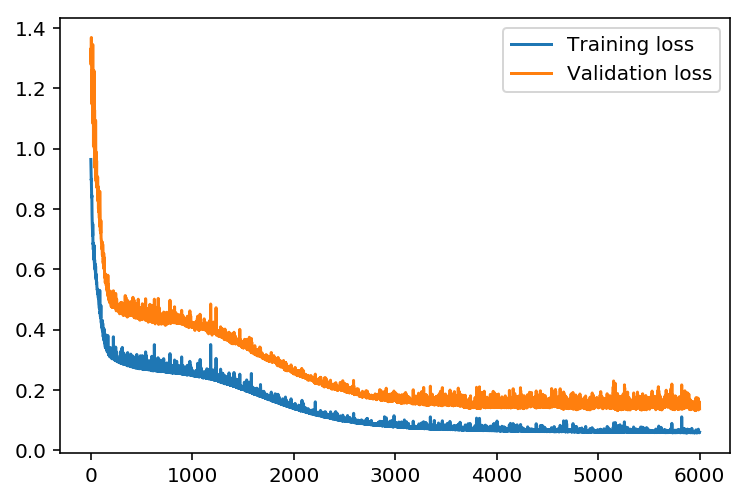

In [15]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## 检查预测结果

使用测试数据看看网络对数据建模的效果如何。如果完全错了，请确保网络中的每步都正确实现。

(504, 1)


D:\python36\Lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


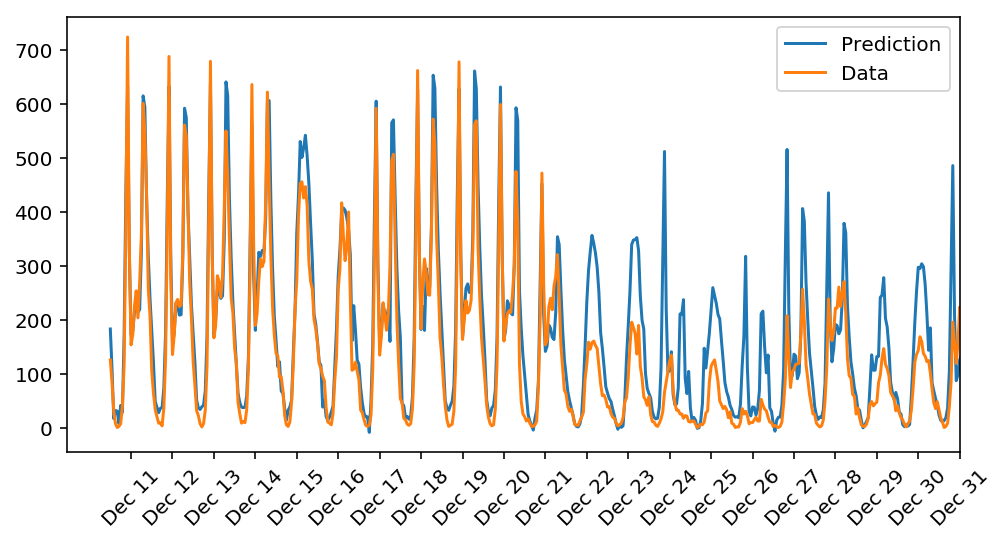

In [16]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## 可选：思考下你的结果（我们不会评估这道题的答案）

 
请针对你的结果回答以下问题。模型对数据的预测效果如何？哪里出现问题了？为何出现问题呢？

> **注意**：你可以通过双击该单元编辑文本。如果想要预览文本，请按 Control + Enter

#### 请将你的答案填写在下方
